# Practica 2
## Eduardo Ceja
## Optimizacion no Lineal

Encontrar la solucion optima para el siguente problema:
$$ 
max f(x) = \frac{0.5}{\sqrt{1 + x^2}} - \sqrt{1 + x^2} (1 - \frac{0.5}{1 + x^2}) + x
$$

Utilizando los metodos de:
* Estimaciones cuadraticas
* Newton Raphson
* Cuasi Newton
* Biseccion
* Secante

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

In [2]:
count_fx = 0
count_df = 0
count_d2f = 0

In [3]:
def f(x):
    global count_fx
    count_fx += 1
    return (0.5/np.sqrt(1 + x**2)) - np.sqrt(1 + x**2) * (1 - (0.5/(1+x**2))) + x

In [4]:
def df(x):
    global count_df
    count_df += 1
    # return 1 - ( x/( (1 + x**2)*(3/2) ) ) - (x/(np.sqrt(1 + x**2)))
    return ((((x**2)+1)**(3/2)) - (x**3) - (2*x) )/(((x**2)+1)**(3/2))# las derivadas que habia calculado a mano, me generaban un error numerico de aproxiamdamente 0.15, (lo suficiente para no encontrar el maximo) por lo que decidi usar otra representacion 

In [5]:
def d2f(x):
    global count_d2f
    count_d2f += 1
    # return (-2*x**2 - 1) /((x**2 + 1)**(5/2)) - 1/((1 + x**2)**(3/2))
    return ((x**2)-2)/(((x**2)+1)**(5/2)) # las derivadas que habia calculado a mano, me generaban un error numerico de aproxiamdamente 0.15, (lo suficiente para no encontrar el maximo) por lo que decidi usar otra representacion 

## Grafica

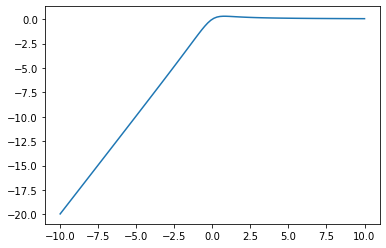

In [6]:
x = np.linspace(-10,10, 100)
plt.plot(x,f(x))

Como es un problema de Maximizacion, lo mas conveniente seria convertirlo en uno de minimizacion para que los algoritmos no sufran muchos cambios, ademas de que es mas sencillo. Para esto, solo tenemos que minimizar $-f(x)$

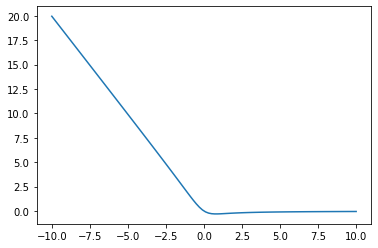

In [7]:
x = np.linspace(-10,10, 100)
plt.plot(x,-f(x))

## Metodos
### Estimaciones cuadraticas


In [8]:
def calc_a(x1 : float, x2 : float, x3: float, f1: float, f2: float, f3 : float) -> Tuple[float]:
    a0 = f1
    a1 = (f2 - f1)/(x2 - x1)
    a2 = (1/(x3-x2)) * ( ( (f3-f1)/(x3-x1) ) - a1)
    return a0,a1,a2

def get_xb(x1 : float, x2 : float, a1:float, a2 : float) -> float:
    return( ((x1+x2)/2) - (a1/(2*a2)) )


def estimaciones_cuadraticas(x1 :float ,delta: float, epsilon: float):
    x2 = x1 + delta
    f1 = - f(x1)
    f2 = - f(x2)

    if f1 > f2:
        x3 = x1 + 2*delta
    else:
        x3 = x1 - delta

    f3 = - f(x3)
    (x1, f1),(x2, f2),(x3, f3) = sorted(((x1,f1),(x2,f2),(x3,f3)), key = lambda x : x[0])

    while True:
        x_min, f_min = min(((x1, f1),(x2, f2),(x3,f3)), key = lambda x : x[1])
        a0,a1,a2 = calc_a(x1,x2,x3,f1,f2,f3)

        if a2 < 0:
            break

        xb =  get_xb(x1,x2,a1,a2)
        
        fb = - f(xb)
        (x1, f1),(x2, f2),(x3,f3) = sorted(((x1, f1),(x2, f2),(x3,f3), (xb,fb)), key = lambda x : x[1])[:3]
        (x1, f1),(x2, f2),(x3, f3) = sorted(((x1,f1),(x2,f2),(x3,f3)), key = lambda x : x[0])

        if abs(x_min - xb) < epsilon:
            break
    
    return (x_min,f_min)

In [9]:
count_fx = 0
count_df = 0
count_d2f = 0
x0 = 0
delta = 0.1
eps = 0.0001
x_max, f_max = estimaciones_cuadraticas(x0, delta, eps)
print(f"({x_max:.3f}, {-f_max:.3f})")
print(f"{count_fx} , {count_df}, {count_d2f}")

(0.786, 0.300)
12 , 0, 0


### Newton Raphson

Para este metodo, se necesitan la primera y segunda derivada. Es por eso, que es necesario calcularlas

tenemos que 
$$
f(x) = \frac{0.5}{\sqrt{1 + x^2}} - \sqrt{1 + x^2} (1 - \frac{0.5}{1 + x^2}) + x
$$
Primera derivada
$$
\frac{0.5}{\sqrt{1 + x^2}} - \sqrt{1 + x^2} (1 - \frac{0.5}{1 + x^2}) + x \\
x + \frac{0.5}{\sqrt{1 + x^2}} - \sqrt{1 + x^2}(1 - \frac{0.5}{1 + x^2}) \\
\frac{d}{dx} x + 0.5 \frac{d}{dx} \frac{1}{\sqrt{1 + x^2}} - \frac{d}{dx}\sqrt{1 + x^2}(1 - \frac{0.5}{1 + x^2}) \\
0.5\frac{d}{dx} \frac{1}{\sqrt{1 + x^2}} - \frac{d}{dx}\sqrt{1 + x^2}(1 - \frac{0.5}{1 + x^2}) + 1 \\
-0.5 \frac{d/dx (1 + x^2)}{2 (1 + x^2)^{3/2}}  -\frac{d}{dx}\left (\sqrt{1 + x^2} * (1 - \frac{0.5}{1 + x^2}) \right) + 1 \\
\frac{-0.25 (d/dx (1 + x^2))}{(1 + x^2)^{3/2}} -\frac{d}{dx}\left (\sqrt{1 + x^2} * (1 - \frac{0.5}{1 + x^2}) \right) + 1 \\
- \frac{0.25 \cdot 2x}{(1 + x^2)^{3/2}} - \frac{d}{dx}\left (\sqrt{1 + x^2} * (1 - \frac{0.5}{1 + x^2}) \right) + 1 \\
$$
Ahora vamos con el termino de en medio
$$
-\frac{d}{dx} \left( \sqrt{1 + x^2} ( 1 - \frac{0.5}{1 + x^2})\right) \\
\frac{1 - 0.5}{1 + x^2} \frac{d}{dx} \sqrt{1 + x^2} - \sqrt{1 + x^2} \frac{d}{dx} 1 - \frac{0.5}{1 + x^2} \\
\frac{\frac{1 - 0.5}{1 + x^2} dx/dx(1 + x^2)}{2\sqrt{1 + x^2}} - \sqrt{1 + x^2} \frac{d}{dx} 1 - \frac{0.5}{1 + x^2} \\
\frac{\frac{1 - 0.5}{1 + x^2} 2x}{2\sqrt{1 + x^2}} - \sqrt{1 + x^2} \frac{d}{dx} 1 - \frac{0.5}{1 + x^2} \\
\frac{\frac{1 - 0.5}{1 + x^2} x}{\sqrt{1 + x^2}} - \sqrt{1 + x^2} \frac{d}{dx} 1 - \frac{0.5}{1 + x^2} \\

$$
La derivada completa
$$
1 - \frac{1.5x}{(1+x^2)^{3/2}} -  \frac{\frac{1 - 0.5}{1 + x^2} x}{\sqrt{1 + x^2}} \\
1 - \frac{x}{(1 + x^2)^{3/2}} - \frac{x}{\sqrt{1 + x^2}}
$$
Para la segunda derivada
$$
\frac{2x^2 - 1}{(x^2 + 1)^{5/2}} - \frac{1}{(1 + x^2)^{3/2}}
$$


In [10]:
# d2f(1)

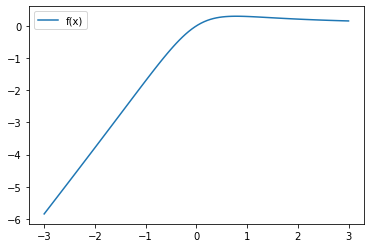

In [11]:
x = np.linspace(-3,3, 100)
plt.plot(x, f(x), label = 'f(x)')
plt.legend()

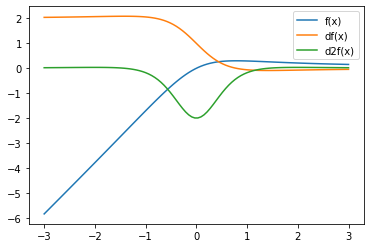

In [12]:
x = np.linspace(-3,3, 100)
plt.plot(x, f(x), label = 'f(x)')
plt.plot(x, df(x), label = 'df(x)')
plt.plot(x, d2f(x), label = 'd2f(x)')
plt.legend()

In [13]:
def newton_raphson(x0, epsilon) -> Tuple[float, float]:
    k = 1
    xk = x0
    dfk = -df(xk)
    while True:
        xk_mas_1 = xk - (dfk/(-d2f( xk )) )
        k += 1
        dfk_1 = -df(xk_mas_1)
        if abs(dfk_1) < epsilon:
            break
        xk = xk_mas_1
        dfk = dfk_1
    return xk_mas_1, -f(xk_mas_1)

In [14]:
count_fx = 0
count_df = 0
count_d2f = 0
x_max, f_max = newton_raphson(x0 = 0, epsilon=0.0001)
print(f"({x_max:.3f},{-f_max:.3f})")
print(f"{count_fx} , {count_df}, {count_d2f}")

(0.786,0.300)
1 , 6, 5


### Cuasi Newtown

In [15]:
def df_cuasi(delta, fx_menos_delta, fx_mas_delta) -> float:
    numerador = fx_mas_delta - fx_menos_delta
    denominador = 2*delta
    return numerador/denominador

def d2f_cuasi(x, delta,  fx_menos_delta, fx_mas_delta) -> float:
    numerador = fx_mas_delta - 2*-f(x) + fx_menos_delta
    denominador = delta**2
    return numerador/denominador

def cuasi_newton(epsilon, x0, delta) -> Tuple[float, float]:
    k = 1
    xk = x0
    fx_mas_delta = -f(xk+delta)
    fx_menos_delta = -f(xk-delta)
    dfk = df_cuasi(delta, fx_menos_delta, fx_mas_delta)
    while True:
        xk_mas_1 = xk - (dfk/d2f_cuasi(xk, delta,  fx_menos_delta, fx_mas_delta))
        k += 1
        f_xk_1_mas_delta = -f(xk_mas_1 + delta )
        f_xk_1_menos_delta = -f(xk_mas_1 - delta )
        dfk_1 = df_cuasi(delta, f_xk_1_menos_delta, f_xk_1_mas_delta)
        if abs(dfk_1) < epsilon:
            break
        xk = xk_mas_1
        dfk = dfk_1
        fx_menos_delta = f_xk_1_menos_delta
        fx_mas_delta = f_xk_1_mas_delta

    return xk_mas_1, -f(xk_mas_1)

In [16]:
count_fx = 0
count_df = 0
count_d2f = 0
x_max, f_max = cuasi_newton(x0 = 0, epsilon=0.0001, delta = 0.01)
print(f"{x_max:.3f}, {-f_max:.3f}")
print(f"{count_fx} , {count_df}, {count_d2f}")

0.786, 0.300
18 , 0, 0


### Bisecciones

In [17]:
def bisecciones(a,b,eps) -> Tuple[float, float]:
    if -df(a) < 0 and -df(b) > 0:
        pass
    else:
        print("Error")
        sys.exit()
    while True:
        z = (a+b)/2
        df_z = -df(z)
        if  df_z < 0:
            a = z
        else:
            b = z

        if abs(df_z) < eps:
            break
    return z, f(z)

In [18]:
count_fx = 0
count_df = 0
count_d2f = 0
z, f_z = bisecciones(0,5, 0.0001)
print(f"{z:.3f}, {f_z:.3f}")
print(f"{count_fx} , {count_df}, {count_d2f}")

0.786, 0.300
1 , 12, 0


### Secante

In [19]:
def metodo_secante(xl,xr,eps) -> Tuple[float,float]:
    df_xr = -df(xr)
    df_xl = -df(xl)
    while True:
        if df_xl * df_xr > 0:
            print("Error")
            sys.exit()
        
        z = xr - (df_xr * (xr - xl))/(df_xr - df_xl)
        df_z = -df(z)
        
        if df_z < 0:
            xl = z
            df_xl = df_z
        else:
            xr = z
            df_xr = df_z

        if abs(df_z) < eps:
            return z, -f(z)

In [20]:
count_fx = 0
count_df = 0
count_d2f = 0
z, f_z = metodo_secante(xl = 0, xr = 5, eps= 0.0001)
print(f"{z:.3f}, {-f_z:.3f}")
print(f"{count_fx} , {count_df}, {count_d2f}")

0.786, 0.300
1 , 56, 0


###  Graficando en el itervalo $[x* - 1, x* + 1]$

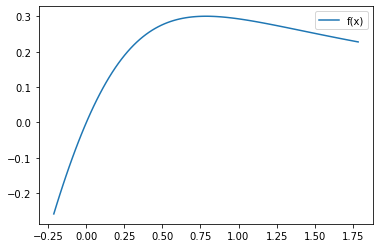

In [21]:
x = np.linspace(0.786 - 1, 0.786 + 1, 100)
plt.plot(x, f(x), label = 'f(x)')
plt.legend()

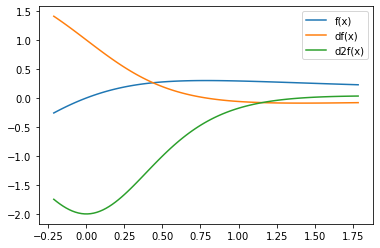

In [22]:
x = np.linspace(0.786 - 1, 0.786 + 1, 100)
plt.plot(x, f(x), label = 'f(x)')
plt.plot(x, df(x), label = 'df(x)')
plt.plot(x, d2f(x), label = 'd2f(x)')
plt.legend()

Ahora se va a trabajar con la funcion

$$
min g(x)  = e^x - x^3
$$

Como es un exponencial y un polinomio, se puede deducir que $g \in \mathcal{C}^\infty$

In [23]:
def g(x):
    return (math.e**x) - (x**3)

Vamos a usar los metodos de cuasi newton y estimaciones

In [24]:
def calc_a(x1 : float, x2 : float, x3: float, f1: float, f2: float, f3 : float) -> Tuple[float]:
    a0 = f1
    a1 = (f2 - f1)/(x2 - x1)
    a2 = (1/(x3-x2)) * ( ( (f3-f1)/(x3-x1) ) - a1)
    return a0,a1,a2

def get_xb(x1 : float, x2 : float, a1:float, a2 : float) -> float:
    return( ((x1+x2)/2) - (a1/(2*a2)) )


def estimaciones_cuadraticas_g(x1 :float ,delta: float, epsilon: float):
    x2 = x1 + delta
    f1 = g(x1)
    f2 = g(x2)

    if f1 > f2:
        x3 = x1 + 2*delta
    else:
        x3 = x1 - delta

    f3 = g(x3)
    (x1, f1),(x2, f2),(x3, f3) = sorted(((x1,f1),(x2,f2),(x3,f3)), key = lambda x : x[0])

    while True:
        x_min, f_min = min(((x1, f1),(x2, f2),(x3,f3)), key = lambda x : x[1])
        a0,a1,a2 = calc_a(x1,x2,x3,f1,f2,f3)

        if a2 < 0:
            break

        xb =  get_xb(x1,x2,a1,a2)
        
        fb = g(xb)
        (x1, f1),(x2, f2),(x3,f3) = sorted(((x1, f1),(x2, f2),(x3,f3), (xb,fb)), key = lambda x : x[1])[:3]
        (x1, f1),(x2, f2),(x3, f3) = sorted(((x1,f1),(x2,f2),(x3,f3)), key = lambda x : x[0])

        if abs(x_min - xb) < epsilon:
            break
    
    return (x_min,f_min)

In [25]:
xg_min, g_min = estimaciones_cuadraticas_g(x1 = 5, epsilon=0.0001, delta = 0.01)
print(f"{xg_min:.3f}, {g_min:.3f}")

3.733, -10.216


Si me acerto a 3 por la derecha si encuetra el minimo, pero si lo hago por la izquierda no lo hace

In [26]:
def dg(x):
    return math.e**x - (3*x**2)

In [27]:
def d2g(x):
    return math.e**x - 6*x

In [28]:
def newton_raphson_g(x0, epsilon) -> Tuple[float, float]:
    k = 1
    xk = x0
    dgk = dg(xk)
    while True:
        xk_mas_1 = xk - (dgk/d2g(xk))
        k += 1
        dgk_1 = dg(xk_mas_1)
        if abs(dgk_1) < epsilon:
            break
        xk = xk_mas_1
        dgk = dgk_1
    return xk_mas_1, g(xk_mas_1)

In [29]:
xg_min, g_min = newton_raphson_g(x0 = 0, epsilon=0.001)
print(f"({xg_min:.3f},{g_min:.3f})")

(-0.459,0.729)


In [30]:
xg_min, g_min = newton_raphson_g(x0 = 10, epsilon=0.001)
print(f"({xg_min:.3f},{g_min:.3f})")

(3.733,-10.216)


Mimsa historia, esto puede ser que esta encontrando un minimo local cercano antes de minimo global, el cual esta en 3.733.

Ahora vamos con el metodo de cuasi newtown

In [31]:
def df_cuasi_g(delta, fx_menos_delta, fx_mas_delta) -> float:
    numerador = fx_mas_delta - fx_menos_delta
    denominador = 2*delta
    return numerador/denominador

def d2f_cuasi_g(x, delta,  fx_menos_delta, fx_mas_delta) -> float:
    numerador = fx_mas_delta - 2*g(x) + fx_menos_delta
    denominador = delta**2
    return numerador/denominador

def cuasi_newton_g(epsilon, x0, delta) -> Tuple[float, float]:
    k = 1
    xk = x0
    fx_mas_delta = g(xk+delta)
    fx_menos_delta = g(xk-delta)
    dfk = df_cuasi_g(delta, fx_menos_delta, fx_mas_delta)
    while True:
        xk_mas_1 = xk - (dfk/d2f_cuasi_g(xk, delta,  fx_menos_delta, fx_mas_delta))
        k += 1
        f_xk_1_mas_delta = g(xk_mas_1 + delta )
        f_xk_1_menos_delta = g(xk_mas_1 - delta )
        dfk_1 = df_cuasi_g(delta, f_xk_1_menos_delta, f_xk_1_mas_delta)
        if abs(dfk_1) < epsilon:
            break
        xk = xk_mas_1
        dfk = dfk_1
        fx_menos_delta = f_xk_1_menos_delta
        fx_mas_delta = f_xk_1_mas_delta

    return xk_mas_1, g(xk_mas_1)

In [32]:
xg_min, g_min = cuasi_newton_g(x0 = 0, epsilon=0.0001, delta = 0.01)
print(f"{xg_min:.3f}, {g_min:.3f}")

-0.459, 0.729


In [33]:
xg_min, g_min = cuasi_newton_g(x0 = 10, epsilon=0.0001, delta = 0.01)
print(f"{xg_min:.3f}, {g_min:.3f}")

3.733, -10.216


Vamos a realizar la grafica en un intervalo cercano al optimo

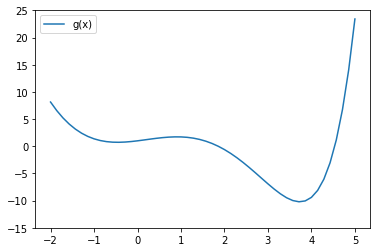

In [34]:
x = np.linspace(-2,5)
plt.ylim(bottom= -15, top = 25)
plt.plot(x,g(x), label = 'g(x)')
plt.legend()

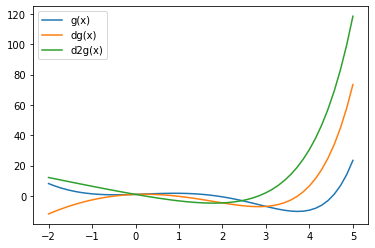

In [35]:
x = np.linspace(-2,5)
plt.plot(x,g(x), label = 'g(x)')
plt.plot(x, dg(x), label = 'dg(x)')
plt.plot(x, d2g(x), label = 'd2g(x)')
plt.legend()

Vemos que efectivamente a la izquierda hay un minimo local antes del minimo global y es por eso que si los metodos se van por la izquierda, se atoran en ese minimo local

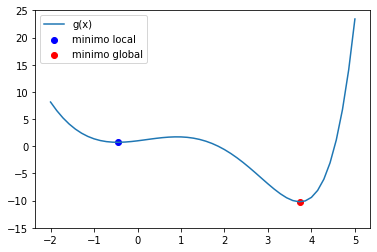

In [36]:
x = np.linspace(-2,5)
plt.ylim(bottom= -15, top = 25)
plt.plot(x,g(x), label = 'g(x)')
plt.scatter(-0.459, g(-0.459), label = 'minimo local', c = 'b')
plt.scatter(3.733, g(3.733), label = 'minimo global', c = 'r')
plt.legend()